In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *

In [2]:
data_type_list = ['world_3d', 'source_list', 'cam_param', 'cam_3d', 'img_2d']
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)
data.keys()

[overwrite: False] ==> Loading H36M world_3d...
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...


dict_keys(['world_3d', 'source_list', 'cam_param', 'cam_3d', 'img_2d'])

In [3]:
source_list = data['source_list'].copy()
source = source_list[0]
subject, cam_id, action = split_source_name(source, dataset_name)
cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, t, R, C, intrinsic = cam_param['W'], cam_param['H'], cam_param['t'], cam_param['R'], cam_param['C'],  cam_param['intrinsic']
world_3d = data['world_3d'][subject][action].copy()

In [29]:
idx = np.where(np.array(source_list) == 'S1_54138969_Walking 1')[0][0]
source_list[idx:idx+4] 

['S1_54138969_Walking 1',
 'S1_60457274_Walking 1',
 'S1_55011271_Walking 1',
 'S1_58860488_Walking 1']

In [44]:
world_3ds = []
cam_3ds = []
cameras = []
cam_ids = []
img_2ds_norm = []
cam_3ds_hat = []
cam_3ds_canonical_same_z = []
img_2ds_canonical_same_z = []
img_2ds_canonical_same_z_norm = []
cam_3ds_canonical_fixed_5 = []
img_2ds_canonical_fixed_5 = []
img_2ds_canonical_fixed_5_norm = []

for source in source_list[idx:idx+4] :
    subject, cam_id, action = split_source_name(source, dataset_name)
    cam_param = data['cam_param'][subject][action][cam_id].copy()
    W, H, t, R, C, intrinsic = cam_param['W'], cam_param['H'], cam_param['t'], cam_param['R'], cam_param['C'],  cam_param['intrinsic']

    camera = Camera(origin=C, 
                    calib_mat=intrinsic, 
                    cam_default_R=R, 
                    roll=0,
                    pitch=0,
                    yaw=0,
                    IMAGE_HEIGHT=H, 
                    IMAGE_WIDTH=W,
                    cam_name=cam_id)
    cameras.append(camera)
    
    img_2d = data['img_2d'][subject][action][cam_id].copy()
    img_2d_norm = normalize_input(img_2d, W, H)
    
    cam_3d = data['cam_3d'][subject][action][cam_id].copy()
    # root-relative
    cam_3d_hat = cam_3d.copy() - cam_3d[:, 0, None]
    # canonical
    cam_3d_canonical_same_z = cam_3d.copy()
    cam_3d_canonical_same_z[..., 0] -= cam_3d[:, 0, 0, None]
    cam_3d_canonical_same_z[..., 1] -= cam_3d[:, 0, 1, None]
    cam_3d_canonical_fixed_5 = cam_3d_hat.copy()
    cam_3d_canonical_fixed_5[..., 2] += 5
    
    world_3ds.append(data['world_3d'][subject][action].copy())
    cam_3ds.append(cam_3d)
    cam_ids.append(cam_id)
    img_2ds_norm.append(img_2d_norm)
    cam_3ds_hat.append(cam_3d_hat)
    cam_3ds_canonical_same_z.append(cam_3d_canonical_same_z)
    cam_3ds_canonical_fixed_5.append(cam_3d_canonical_fixed_5)
    
    img_2d_canonical_same_z = projection(cam_3d_canonical_same_z, intrinsic)
    img_2d_canonical_same_z_norm = normalize_input(img_2d_canonical_same_z, W, H)
    img_2d_canonical_fixed_5 = projection(cam_3d_canonical_fixed_5, intrinsic)
    img_2d_canonical_fixed_5_norm = normalize_input(img_2d_canonical_fixed_5, W, H)
    
    img_2ds_canonical_same_z.append(img_2d_canonical_same_z)
    img_2ds_canonical_same_z_norm.append(img_2d_canonical_same_z_norm)
    img_2ds_canonical_fixed_5.append(img_2d_canonical_fixed_5)
    img_2ds_canonical_fixed_5_norm.append(img_2d_canonical_fixed_5_norm)

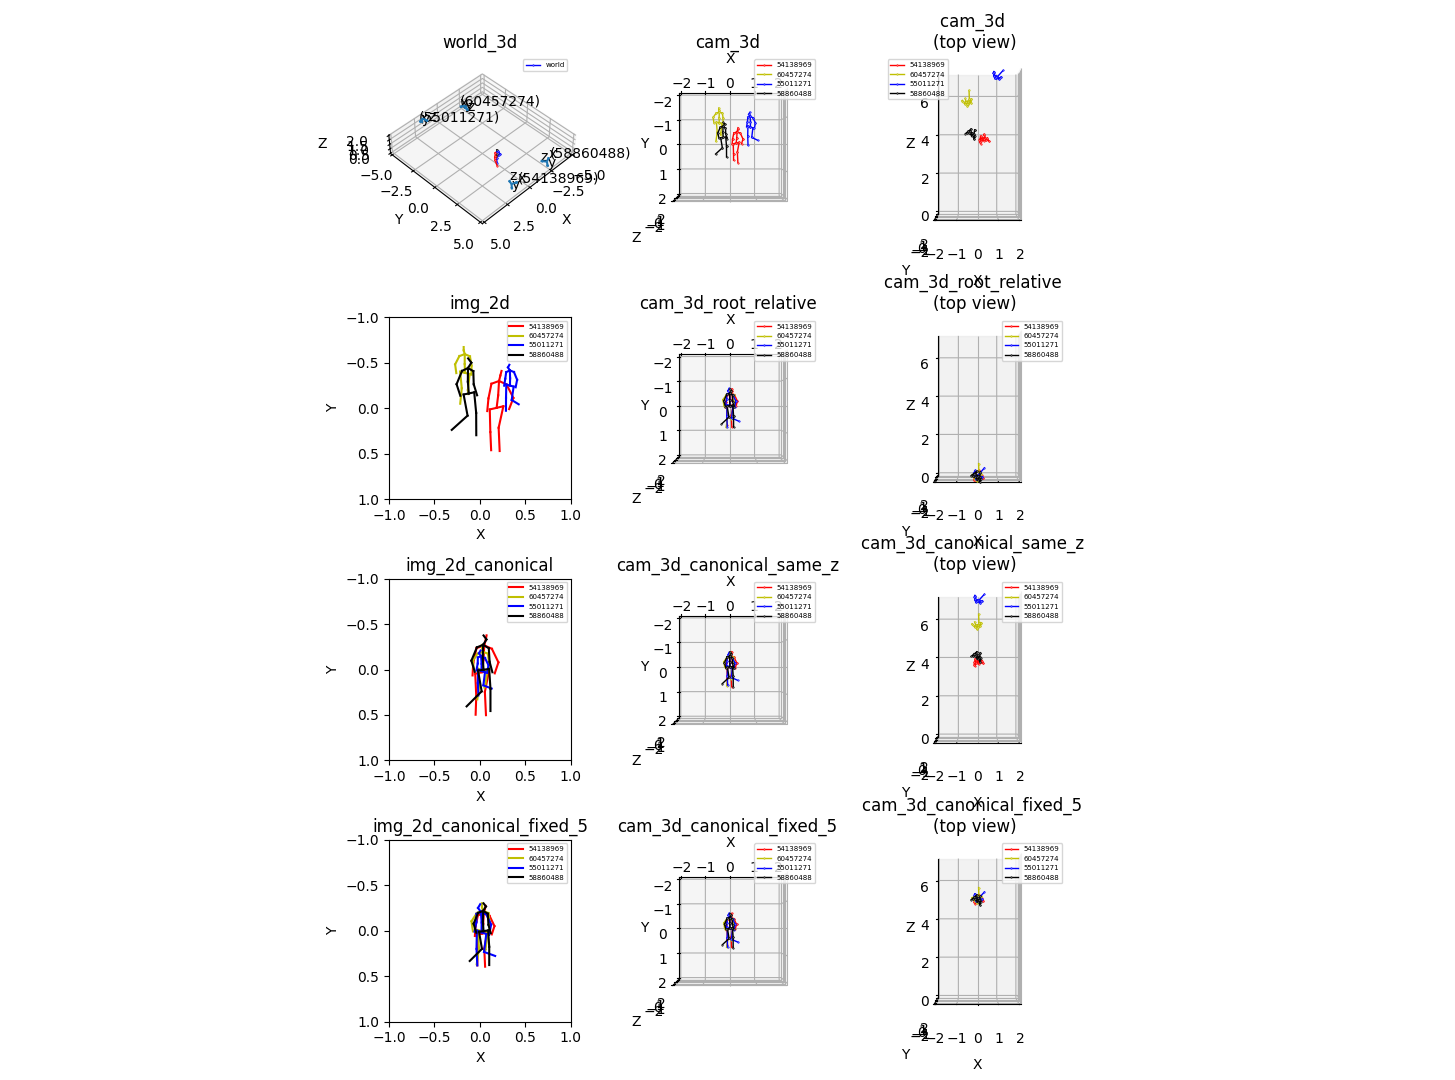

In [57]:
frame_num = 1000

configs = {
    'ax_world':     {'type': '3d', 'loc': 431, 'mode': 'world', 'xlim': (-5, 5), 'ylim': (-5, 5),'zlim': (0, 2), 'view': (45, 45), 'title': 'world_3d'},
    'ax_cam':       {'type': '3d', 'loc': 432, 'mode': 'cam', 'title': 'cam_3d'},
    'ax_cam2':      {'type': '3d', 'loc': 433, 'mode': 'world', 'xlim': (-2, 2), 'ylim': (-2, 2),'zlim': (0, 7), 'view': (0, -90), 'title': 'cam_3d \n(top view)'},
    'ax_img':       {'type': '2d', 'loc': 434, 'normalize': True, 'title': 'img_2d'},
    'ax_cam_rr':    {'type': '3d', 'loc': 435, 'mode': 'cam', 'title': 'cam_3d_root_relative'},
    'ax_cam_rr2':   {'type': '3d', 'loc': 436, 'mode': 'world', 'xlim': (-2, 2), 'ylim': (-2, 2),'zlim': (0, 7), 'view': (0, -90), 'title': 'cam_3d_root_relative \n(top view)'},
    'ax_img_casz':  {'type': '2d', 'loc': 437, 'normalize': True, 'title': 'img_2d_canonical'},
    'ax_cam_casz':  {'type': '3d', 'loc': 438, 'mode': 'cam', 'title': 'cam_3d_canonical_same_z'},
    'ax_cam_casz2': {'type': '3d', 'loc': 439, 'mode': 'world', 'xlim': (-2, 2), 'ylim': (-2, 2),'zlim': (0, 7), 'view': (0, -90), 'title': 'cam_3d_canonical_same_z \n(top view)'},
    'ax_img_caf5':  {'type': '2d', 'locvec': [4,3,10], 'normalize': True, 'title': 'img_2d_canonical_fixed_5'},
    'ax_cam_caf5':  {'type': '3d', 'locvec': [4,3,11], 'mode': 'cam', 'title': 'cam_3d_canonical_fixed_5'},
    'ax_cam_caf52': {'type': '3d', 'locvec': [4,3,12], 'mode': 'world', 'xlim': (-2, 2), 'ylim': (-2, 2),'zlim': (0, 7), 'view': (0, -90), 'title': 'cam_3d_canonical_fixed_5 \n(top view)'},
}
fig, axs = generate_axes(3, configs, figsize=(20, 15))
plot_pose_setting = [
    ('ax_world',   world_3ds[0],   {'label': 'world', 'dataset': 'h36m'}),
    ('ax_cam',     cam_3ds[0],     {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam',     cam_3ds[1],     {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam',     cam_3ds[2],     {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam',     cam_3ds[3],     {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_cam2',    cam_3ds[0],     {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam2',    cam_3ds[1],     {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam2',    cam_3ds[2],     {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam2',    cam_3ds[3],     {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_img',     img_2ds_norm[0],  {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_img',     img_2ds_norm[1],  {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_img',     img_2ds_norm[2],  {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_img',     img_2ds_norm[3],  {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_cam_rr',  cam_3ds_hat[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam_rr',  cam_3ds_hat[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam_rr',  cam_3ds_hat[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam_rr',  cam_3ds_hat[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_cam_rr2', cam_3ds_hat[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam_rr2', cam_3ds_hat[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam_rr2', cam_3ds_hat[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam_rr2', cam_3ds_hat[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_cam_casz',  cam_3ds_canonical_same_z[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam_casz',  cam_3ds_canonical_same_z[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam_casz',  cam_3ds_canonical_same_z[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam_casz',  cam_3ds_canonical_same_z[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_cam_casz2', cam_3ds_canonical_same_z[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam_casz2', cam_3ds_canonical_same_z[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam_casz2', cam_3ds_canonical_same_z[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam_casz2', cam_3ds_canonical_same_z[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_img_casz',  img_2ds_canonical_same_z_norm[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_img_casz',  img_2ds_canonical_same_z_norm[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_img_casz',  img_2ds_canonical_same_z_norm[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_img_casz',  img_2ds_canonical_same_z_norm[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_cam_caf5',  cam_3ds_canonical_fixed_5[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam_caf5',  cam_3ds_canonical_fixed_5[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam_caf5',  cam_3ds_canonical_fixed_5[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam_caf5',  cam_3ds_canonical_fixed_5[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_cam_caf52', cam_3ds_canonical_fixed_5[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_cam_caf52', cam_3ds_canonical_fixed_5[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_cam_caf52', cam_3ds_canonical_fixed_5[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_cam_caf52', cam_3ds_canonical_fixed_5[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
    ('ax_img_caf5',  img_2ds_canonical_fixed_5_norm[0], {'label': cam_ids[0], 'dataset': 'h36m', 'color': 'r'}),
    ('ax_img_caf5',  img_2ds_canonical_fixed_5_norm[1], {'label': cam_ids[1], 'dataset': 'h36m', 'color': 'y'}),
    ('ax_img_caf5',  img_2ds_canonical_fixed_5_norm[2], {'label': cam_ids[2], 'dataset': 'h36m', 'color': 'b'}),
    ('ax_img_caf5',  img_2ds_canonical_fixed_5_norm[3], {'label': cam_ids[3], 'dataset': 'h36m', 'color': 'k'}),
]

general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.sca(axs['ax_world'])
for camera in cameras:
    camera.cam_frame.draw3d()
plt.tight_layout()
plt.show()

In [58]:
plt.savefig(f"custom_codes/canonical/figures/{source}_frame{frame_num}.png", bbox_inches='tight', dpi=300)